## Import modules

In [1]:
#%matplotlib ipympl

import matplotlib.pyplot as plt
import numpy as np
import obspy
import pandas as pd

## Define the picking function with option to plot waveforms with picks

In [22]:
def pick(wf_file, md_file, recordlength=1.5, plot=False):
    df_sta = pd.read_csv(md_file, delim_whitespace=True, header=None, names=['sta', 'net', 'x', '_y', '?', '??'])
    df_sta['y'] = 3e3 - df_sta['_y']
    
    df = pd.DataFrame()
    st = obspy.read(wf_file)
    for idx in range(len(st)):
        tr = st[idx]
        tr.stats.network  = 'AA'
        tr.stats.station  = df_sta.loc[idx, 'sta']
        tr.stats.channel  = 'DPZ'
        tr.stats.distance = df_sta.loc[idx, 'x']
        firstarr = np.nonzero(tr.data > np.median(np.abs(tr)) * 5)[0][0]
        tr.stats.t0_first = firstarr * tr.stats.delta
        tr.stats.t0_max   = np.argmax(np.abs(tr)) * tr.stats.delta
        window = int(0.3/tr.stats.delta)
        tr.stats.t0_max   = (firstarr+np.argmax(np.abs(tr.data[firstarr:firstarr+window])))*tr.stats.delta
        df = df.append(
            pd.DataFrame(
                [[tr.stats.station, tr.stats.t0_first, tr.stats.t0_max]],
                columns=['sta', 't0_first', 't0_max']
            ),
            ignore_index=True
        )

    if plot is True:
        fig = st.plot(
            type='section', 
            time_down=True,
            recordlength=recordlength,
            fillcolors=('k', 'w'), 
            handle=True
        )

        ax = fig.axes[0]
        xmin, xmax = ax.get_xlim()
        delta_x    = xmax - xmin

        pick_marker_half_width = 1/(2.5*len(st))
        for tr in st:
            ax.axhline(
                y=tr.stats.t0_first,
                xmin=(tr.stats.distance * 1e-3 - xmin)/delta_x-pick_marker_half_width,
                xmax=(tr.stats.distance * 1e-3 - xmin)/delta_x+pick_marker_half_width,
                color='r'
            )
            ax.axhline(
                y=tr.stats.t0_max,
                xmin=(tr.stats.distance * 1e-3 - xmin)/delta_x-pick_marker_half_width,
                xmax=(tr.stats.distance * 1e-3 - xmin)/delta_x+pick_marker_half_width,
                color='b'
            )
    return (df)

## Pick times are return as a pandas.DataFrame

In [6]:
pick('../data/wfs/00012.su', '../data/STATIONS')

,sta,t0_first,t0_max
0,S0001,0.7218,0.7632
1,S0002,0.6876,0.7299
2,S0003,0.6543,0.6984
3,S0004,0.6228,0.6687
4,S0005,0.5940,0.6408
5,S0006,0.5688,0.6147
6,S0007,0.5454,0.5931
7,S0008,0.5229,0.5706
8,S0009,0.5058,0.5508
9,S0010,0.4887,0.5355


## Plot waveforms with picks

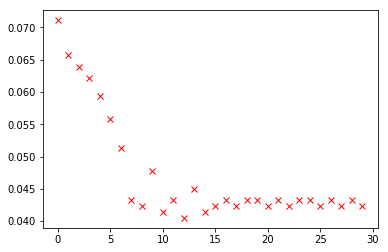

In [24]:
plt.plot(df['t0_max']-df['t0_first'],'rx')
# plt.plot(df['t0_max'],'bo')

In [21]:
df

,sta,t0_first,t0_max
0,S0001,1.3419,1.6596
1,S0002,1.3005,1.6254
2,S0003,1.2591,1.3230
3,S0004,1.2195,1.2816
4,S0005,1.1808,1.2402
5,S0006,1.1430,1.1988
6,S0007,1.1079,1.1592
7,S0008,1.0764,1.1196
8,S0009,1.0413,1.0836
9,S0010,1.0008,1.0485


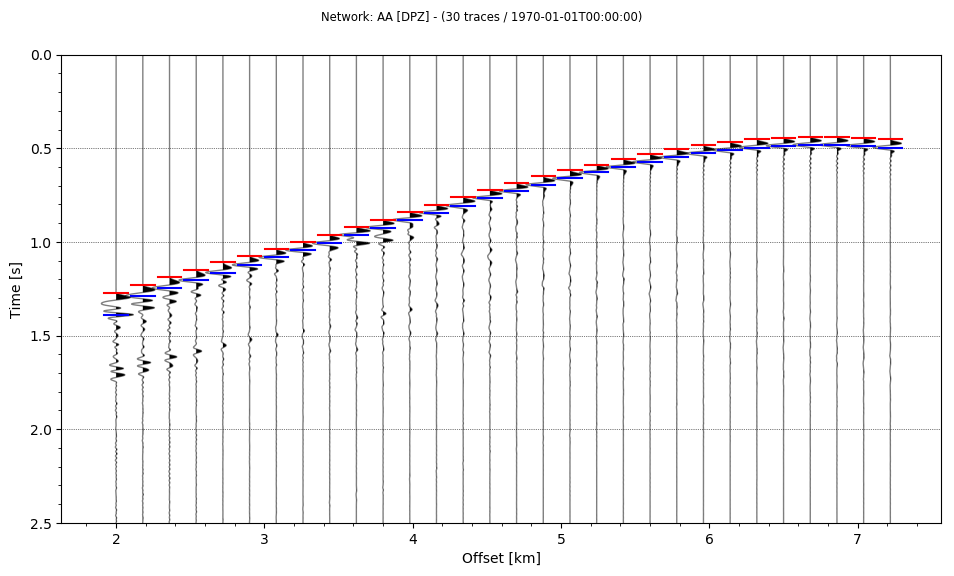

In [33]:
df = pick('../data/wfs/00028.su', '../data/STATIONS',recordlength=2.5, plot=True)

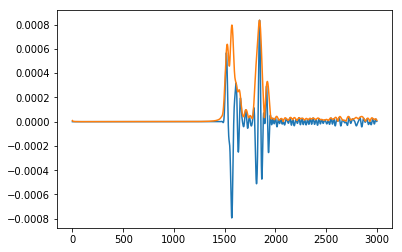

In [34]:
from scipy.signal import hilbert
st = obspy.read('../data/wfs/00029.su')
tr = st[0]
data = tr.data
adata = abs(hilbert(data))
plt.plot(data)
plt.plot(adata)